In [1]:
import json
from sklearn.model_selection import train_test_split

import numpy as np
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.io import read_image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, DataLoader
from Scripts import data_loader, transforms
from Models import CRNN

import Scripts.training_loop as training_loop
importlib.reload(training_loop)

/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<module 'Scripts.train' from '/home/dornika/OCR_Project/Scripts/train.py'>

In [17]:
# Open and read the JSON file
with open('char_to_index.json', 'r') as file:
    data = json.load(file)
char_list = data["char_to_index_list"]
char_to_index = data["char_to_index"]
print(char_list)
print(char_to_index)

['!', '%', '(', ')', '*', '+', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '«', '»', '،', '؛', '؟', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '\u200c', '“', '”', 'ء', ' ']
{'!': 1, '%': 2, '(': 3, ')': 4, '*': 5, '+': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '«': 20, '»': 21, '،': 22, '؛': 23, '؟': 24, 'ئ': 25, 'ا': 26, 'ب': 27, 'ت': 28, 'ث': 29, 'ج': 30, 'ح': 31, 'خ': 32, 'د': 33, 'ذ': 34, 'ر': 35, 'ز': 36, 'س': 37, 'ش': 38, 'ص': 39, 'ض': 40, 'ط': 41, 'ظ': 42, 'ع': 43, 'غ': 44, 'ف': 45, 'ق': 46, 'ل': 47, 'م': 48, 'ن': 49, 'ه': 50, 'و': 51, 'پ': 52, 'چ': 53, 'ژ': 54, 'ک': 55, 'گ': 56, 'ی': 57, '\u200c': 58, '“': 59, '”': 60, 'ء': 61, ' ': 62}


(32, 100)
(32, 100, 1)
tensor([[[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]], dtype=torch.uint8)


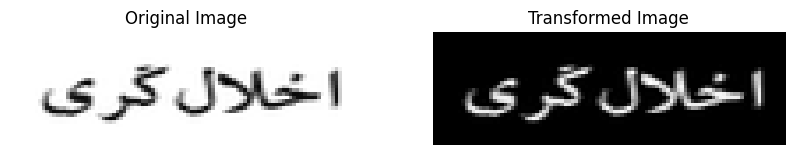

In [18]:
# Load grayscale image
image_path = 'Data/persian_unique_ocr_dataset/generated_data/g_14.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert to NumPy array
image_np = np.array(image)
print(image_np.shape)
image_np = np.expand_dims(image_np, axis=2)
print(image_np.shape)
# Apply transformations
transformed = transforms.Training_transforms(image=image_np)
transformed_image = transformed['image']
print(transformed_image)
# Visualize the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')  # Squeeze for grayscale
plt.axis('off')

plt.show()


In [19]:
df = pd.read_csv("Data/train_data.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
tdf = pd.read_csv("Data/test_data.csv")
tdf = tdf.loc[:, ~tdf.columns.str.contains('^Unnamed')]

In [20]:
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
99260,همیشه,The_Schopenhauer_cure_data_annotated/page_0017...
99261,که از,The_Schopenhauer_cure_data_annotated/page_0192...
99262,سلب,The_Schopenhauer_cure_data_annotated/page_0019...
99263,همان‌گونه,The_Schopenhauer_cure_data_annotated/page_0023...


In [21]:
tdf

,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تاثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
...,...,...
6802,در,The_Schopenhauer_cure_data_annotated/page_0008...
6803,ایا,The_Schopenhauer_cure_data_annotated/page_0020...
6804,فراز,The_Schopenhauer_cure_data_annotated/page_0017...
6805,کامل,The_Schopenhauer_cure_data_annotated/page_0020...


In [22]:
dataset = df.set_index('path')['label'].to_dict()
print(len(dataset))
dict(list(dataset.items())[0:10])


99265


{'04468_153_86244.png': 'درکنار',
 '04335_0_275410.png': '4335',
 '05065_71_1234560.png': 'وتولد',
 '00459_42_782347.png': 'تراژدی\u200cای',
 '02664_92_166182.png': 'افزود:استفاده',
 '02250_87_77933.png': 'ریزگردها',
 '06715_66_498681.png': 'سالگذشته',
 '05562_35_186468.png': 'هولناک',
 '06711_29_9457.png': 'اباالحسن',
 '02937_30_899678.png': 'مواردرا'}

1.3 Custom Torch dataclass

In [23]:
tdataset = tdf.set_index('path')['label'].to_dict()
print(len(tdataset))
dict(list(tdataset.items())[0:10])


6807


{'04964_166_518242.png': 'اغماض،',
 '05210_164_648841.png': 'مرجعیت',
 '04692_131_543131.png': 'تاثر،',
 '05069_183_579292.png': 'همکاریشیما',
 '05066_145_652706.png': 'داستان\u200cنویس،',
 '04284_139_1015608.png': 'وفقط',
 '04558_156_35334.png': 'صحرایی',
 '03445_105_141224.png': 'دریافت.',
 '03051_25_39708.png': 'قطار',
 '04444_74_37847.png': 'افشای'}

1.4 Apply Data Augmentation and Preprocessing

1.5 Split data to Train, test and validation with proportion of 80%, 10% and 10% respectively.

In [24]:
img_dir = "Data/persian_unique_ocr_dataset"

In [25]:
import importlib
importlib.reload(data_loader)

train_dataset = data_loader.OCRDataset(img_dir,dataset , char_to_index , input_length=24,transform=transforms.Training_transforms)
val_dataset = data_loader.OCRDataset(img_dir,tdataset , char_to_index , input_length=24,transform=transforms.Testing_transforms)

Preloading Images: 100%|██████████| 6807/6807 [00:01<00:00, 6506.11it/s]


In [26]:
def collate_fn(batch):
    """Custom collate function to handle variable-length sequences.

    Args:
        batch: A list of data samples, where each sample is a tuple
                of (image, label, length).

    Returns:
        A tuple containing:
            images: A batched tensor of images.
            labels: A padded tensor of labels.
            target_lengths: A tensor of label lengths.
    """
    images, labels, input_lengths, tagret_lengths = zip(*batch)

    # Pad the labels to the maximum length in the batch
    labels = pad_sequence([label.clone().detach() for label in labels], 
                    batch_first=True, padding_value=0)
    # Stack the images and lengths
    # images = images.tensor(images)
    images = torch.stack(images, 0)
    input_lengths = torch.tensor(input_lengths)
    tagret_lengths = torch.tensor(tagret_lengths)

    return images, labels, input_lengths, tagret_lengths

In [27]:
train_data = DataLoader(train_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn , num_workers= 4)
val_data = DataLoader(val_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn, num_workers= 4)

In [28]:
num_classes = 63  # Adjust for Persian characters + numbers + punctuation + blank token
model = CRNN(num_classes=num_classes)
# Define CTC Loss and Optimizer
criterion = nn.CTCLoss(blank=0)  # 0 as the blank token index
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch:  [1/150]
Train_Loss: 3.8329095458984375, Train_character_accuracy: 3.232313655097588e-05, Train_word_accuracy: 0.0, Train_CER: 1.0004418532658599
Val_Loss: 3.8046749319349016, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.8329095458984375 -> 3.8329095458984375
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.8046749319349016 -> 3.8046749319349016
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0004418532658599 -> 1.0004418532658599
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 1.0 -> 1.0
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v

Epoch:  [2/150]
Train_Loss: 3.489971652030945, Train_character_accuracy: 0.0, Train_word_accuracy: 0.0, Train_CER: 1.0
Val_Loss: 3.7758469581604004, Val_character_accuracy: 0.0, Val_word_accuracy: 0.0, Val_CER: 1.0
Improved Train_Loss: 3.8329095458984375 -> 3.489971652030945
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.8046749319349016 -> 3.7758469581604004
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0004418532658599 -> 1.0
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.


Epoch:  [3/150]
Train_Loss: 3.380731716156006, Train_character_accuracy: 0.025369790098704957, Train_word_accuracy: 0.0, Train_CER: 0.961442289723909
Val_Loss: 3.435692378452846, Val_character_accuracy: 0.008609731981538627, Val_word_accuracy: 0.0, Val_CER: 0.9624383480156956
Improved Train_Loss: 3.489971652030945 -> 3.380731716156006
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.7758469581604004 -> 3.435692378452846
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 1.0 -> 0.961442289723909
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 1.0 -> 0.9624383480156956
Model checkpoint saved for metric 'Val_CER' 

Epoch:  [4/150]
Train_Loss: 3.1168411350250245, Train_character_accuracy: 0.05093132244135208, Train_word_accuracy: 0.0, Train_CER: 0.9170320470174393
Val_Loss: 3.75838371685573, Val_character_accuracy: 0.008013309255699931, Val_word_accuracy: 0.0, Val_CER: 0.9716356909173124
Improved Train_Loss: 3.380731716156006 -> 3.1168411350250245
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.961442289723909 -> 0.9170320470174393
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.025369790098704957 -> 0.05093132244135208
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character_accuracy.txt'.


Epoch:  [5/150]
Train_Loss: 2.9973031544685362, Train_character_accuracy: 0.05783560829493068, Train_word_accuracy: 0.0, Train_CER: 0.893645818606026
Val_Loss: 3.2772080217088972, Val_character_accuracy: 0.03492184896845078, Val_word_accuracy: 0.0, Val_CER: 0.8873868985592219
Improved Train_Loss: 3.1168411350250245 -> 2.9973031544685362
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.435692378452846 -> 3.2772080217088972
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.9170320470174393 -> 0.893645818606026
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.9624383480156956 -> 0.8873868985592219
Model checkp

Epoch:  [6/150]
Train_Loss: 2.8621919775009155, Train_character_accuracy: 0.07309148483406559, Train_word_accuracy: 5.037022112527074e-05, Train_CER: 0.8586654018256297
Val_Loss: 3.017610924584525, Val_character_accuracy: 0.0736000383693732, Val_word_accuracy: 0.0007345379756133392, Val_CER: 0.827712472060202
Improved Train_Loss: 2.9973031544685362 -> 2.8621919775009155
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.2772080217088972 -> 3.017610924584525
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.893645818606026 -> 0.8586654018256297
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.8873868985592219 

Epoch:  [7/150]
Train_Loss: 2.698806195259094, Train_character_accuracy: 0.09873308315706676, Train_word_accuracy: 0.0018838462700851257, Train_CER: 0.796730970747996
Val_Loss: 2.613844326564244, Val_character_accuracy: 0.12248054313677068, Val_word_accuracy: 0.03129131776112825, Val_CER: 0.730431824757519
Improved Train_Loss: 2.8621919775009155 -> 2.698806195259094
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 3.017610924584525 -> 2.613844326564244
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.8586654018256297 -> 0.796730970747996
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.827712472060202 -> 0.7

Epoch:  [8/150]
Train_Loss: 2.4854710149765014, Train_character_accuracy: 0.1492551554289902, Train_word_accuracy: 0.04074950889034403, Train_CER: 0.7015930075286346
Val_Loss: 2.4186746733529225, Val_character_accuracy: 0.15841893109028937, Val_word_accuracy: 0.11032760393712356, Val_CER: 0.6624022048989001
Improved Train_Loss: 2.698806195259094 -> 2.4854710149765014
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.613844326564244 -> 2.4186746733529225
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.796730970747996 -> 0.7015930075286346
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.730431824757519 -> 0

Epoch:  [9/150]
Train_Loss: 2.256267216205597, Train_character_accuracy: 0.176164616521955, Train_word_accuracy: 0.05647509192565355, Train_CER: 0.6339147126428648
Val_Loss: 2.122710943222046, Val_character_accuracy: 0.1791008968206915, Val_word_accuracy: 0.1128250330542089, Val_CER: 0.5954595153471315
Improved Train_Loss: 2.4854710149765014 -> 2.256267216205597
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.4186746733529225 -> 2.122710943222046
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.7015930075286346 -> 0.6339147126428648
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.6624022048989001 -> 0.59

Epoch:  [10/150]
Train_Loss: 1.9889410603046418, Train_character_accuracy: 0.20293827290364744, Train_word_accuracy: 0.06632750717775651, Train_CER: 0.5597546224098892
Val_Loss: 1.9061342307499476, Val_character_accuracy: 0.20069763286421918, Val_word_accuracy: 0.10944615836638755, Val_CER: 0.5442303921369592
Improved Train_Loss: 2.256267216205597 -> 1.9889410603046418
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 2.122710943222046 -> 1.9061342307499476
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.6339147126428648 -> 0.5597546224098892
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.5954595153471315 

Epoch:  [11/150]
Train_Loss: 1.6999500226974487, Train_character_accuracy: 0.23797810851185994, Train_word_accuracy: 0.07902080290132474, Train_CER: 0.4817488932151704
Val_Loss: 1.5171102455684118, Val_character_accuracy: 0.2603639704054888, Val_word_accuracy: 0.14793594828852652, Val_CER: 0.4492921480360877
Improved Train_Loss: 1.9889410603046418 -> 1.6999500226974487
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.9061342307499476 -> 1.5171102455684118
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.5597546224098892 -> 0.4817488932151704
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.5442303921369592

Epoch:  [12/150]
Train_Loss: 1.4281194376945496, Train_character_accuracy: 0.2809870592917552, Train_word_accuracy: 0.10027703621618898, Train_CER: 0.4090656854856218
Val_Loss: 1.1624796390533447, Val_character_accuracy: 0.34756974294352516, Val_word_accuracy: 0.20346701924489496, Val_CER: 0.3431729004227898
Improved Train_Loss: 1.6999500226974487 -> 1.4281194376945496
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.5171102455684118 -> 1.1624796390533447
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.4817488932151704 -> 0.4090656854856218
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.4492921480360877

Epoch:  [13/150]
Train_Loss: 1.157851973772049, Train_character_accuracy: 0.3359740331263851, Train_word_accuracy: 0.14079484208935678, Train_CER: 0.33680190028298607
Val_Loss: 0.9290383628436497, Val_character_accuracy: 0.40377511014276357, Val_word_accuracy: 0.2654620243866608, Val_CER: 0.2804984068866833
Improved Train_Loss: 1.4281194376945496 -> 1.157851973772049
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 1.1624796390533447 -> 0.9290383628436497
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.4090656854856218 -> 0.33680190028298607
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.3431729004227898 

Epoch:  [14/150]
Train_Loss: 0.9436758941411972, Train_character_accuracy: 0.3975445002819761, Train_word_accuracy: 0.19978844507127386, Train_CER: 0.2760851582586333
Val_Loss: 0.7390326857566833, Val_character_accuracy: 0.46721306615253766, Val_word_accuracy: 0.3475833700602321, Val_CER: 0.22122865708145564
Improved Train_Loss: 1.157851973772049 -> 0.9436758941411972
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.9290383628436497 -> 0.7390326857566833
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.33680190028298607 -> 0.2760851582586333
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.2804984068866833

Epoch:  [15/150]
Train_Loss: 0.7752838331460953, Train_character_accuracy: 0.45622436471887046, Train_word_accuracy: 0.2644335868634463, Train_CER: 0.22731833876874938
Val_Loss: 0.6511451091085162, Val_character_accuracy: 0.5319320954738191, Val_word_accuracy: 0.3848978992213897, Val_CER: 0.20191772545232217
Improved Train_Loss: 0.9436758941411972 -> 0.7752838331460953
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.7390326857566833 -> 0.6511451091085162
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.2760851582586333 -> 0.22731833876874938
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.221228657081455

Epoch:  [16/150]
Train_Loss: 0.6483324849605561, Train_character_accuracy: 0.5116436572009438, Train_word_accuracy: 0.3298745781493981, Train_CER: 0.18934463455694509
Val_Loss: 0.5195352946008954, Val_character_accuracy: 0.5958464391870774, Val_word_accuracy: 0.4892022917584839, Val_CER: 0.14900853557750882
Improved Train_Loss: 0.7752838331460953 -> 0.6483324849605561
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.6511451091085162 -> 0.5195352946008954
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.22731833876874938 -> 0.18934463455694509
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.201917725452322

Epoch:  [17/150]
Train_Loss: 1.971131312251091, Train_character_accuracy: 0.32128065225331204, Train_word_accuracy: 0.20004029617690022, Train_CER: 0.5106988308512009
Val_Loss: 3.0651132379259383, Val_character_accuracy: 0.05449064346500779, Val_word_accuracy: 0.00029381519024533566, Val_CER: 0.8677606431242398


Epoch:  [18/150]
Train_Loss: 2.704102656841278, Train_character_accuracy: 0.11717491111650348, Train_word_accuracy: 0.013690626101848588, Train_CER: 0.7685999362212028
Val_Loss: 2.6294260365622386, Val_character_accuracy: 0.14782956913255693, Val_word_accuracy: 0.07712648743940062, Val_CER: 0.709224120231172


Epoch:  [19/150]
Train_Loss: 2.3275655627250673, Train_character_accuracy: 0.17718161920413644, Train_word_accuracy: 0.04665289880622576, Train_CER: 0.6428779359628604
Val_Loss: 2.043795108795166, Val_character_accuracy: 0.20512657096519568, Val_word_accuracy: 0.11311884824445424, Val_CER: 0.570465464460617


Epoch:  [20/150]
Train_Loss: 1.9273931896686554, Train_character_accuracy: 0.22041479934953662, Train_word_accuracy: 0.06071626454440135, Train_CER: 0.5410075338285185
Val_Loss: 1.5791853836604528, Val_character_accuracy: 0.27193854067711726, Val_word_accuracy: 0.1338328191567504, Val_CER: 0.46126707751873003


Epoch:  [21/150]
Train_Loss: 1.4946213221549989, Train_character_accuracy: 0.2834474046497946, Train_word_accuracy: 0.08899410668412834, Train_CER: 0.42663216258995224
Val_Loss: 1.1532711131232125, Val_character_accuracy: 0.35013574538491576, Val_word_accuracy: 0.19215513442044954, Val_CER: 0.34642980870393775


Epoch:  [22/150]
Train_Loss: 1.1390431678295136, Train_character_accuracy: 0.35289500009809044, Train_word_accuracy: 0.14399838815292398, Train_CER: 0.331466233274776
Val_Loss: 0.8837186012949262, Val_character_accuracy: 0.4564313489200242, Val_word_accuracy: 0.287057440869693, Val_CER: 0.2595649681921164


Epoch:  [23/150]
Train_Loss: 0.8939380443096161, Train_character_accuracy: 0.4216119173866737, Train_word_accuracy: 0.21435551302070216, Train_CER: 0.2616228145221245
Val_Loss: 0.6639628410339355, Val_character_accuracy: 0.5336550499646953, Val_word_accuracy: 0.4001762891141472, Val_CER: 0.18833376073349634


Epoch:  [24/150]
Train_Loss: 0.7289067941904068, Train_character_accuracy: 0.48173426763559596, Train_word_accuracy: 0.2866367803354657, Train_CER: 0.21350421309243656
Val_Loss: 0.5646820749555316, Val_character_accuracy: 0.5876097817087086, Val_word_accuracy: 0.462612017041281, Val_CER: 0.15822540419279077


Epoch:  [25/150]
Train_Loss: 0.6108060079813004, Train_character_accuracy: 0.5349801448948138, Train_word_accuracy: 0.35392132171460233, Train_CER: 0.17701911919183883
Val_Loss: 0.4556328271116529, Val_character_accuracy: 0.6528079370532316, Val_word_accuracy: 0.5488467753782871, Val_CER: 0.12569609030605078
Improved Train_Loss: 0.6483324849605561 -> 0.6108060079813004
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.5195352946008954 -> 0.4556328271116529
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.18934463455694509 -> 0.17701911919183883
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.14900853557750

Epoch:  [26/150]
Train_Loss: 0.5231718376278878, Train_character_accuracy: 0.5786910863422234, Train_word_accuracy: 0.4123104820430162, Train_CER: 0.1509888715190182
Val_Loss: 0.40487215348652433, Val_character_accuracy: 0.6585462678143452, Val_word_accuracy: 0.5585426766563831, Val_CER: 0.1190452064625711
Improved Train_Loss: 0.6108060079813004 -> 0.5231718376278878
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.4556328271116529 -> 0.40487215348652433
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.17701911919183883 -> 0.1509888715190182
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.1256960903060507

Epoch:  [27/150]
Train_Loss: 0.4583071893453598, Train_character_accuracy: 0.6170476428810203, Train_word_accuracy: 0.45997078527174734, Train_CER: 0.13143407964064807
Val_Loss: 0.3531330057552883, Val_character_accuracy: 0.7185444309355821, Val_word_accuracy: 0.618774790656677, Val_CER: 0.09783524345005189
Improved Train_Loss: 0.5231718376278878 -> 0.4583071893453598
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.40487215348652433 -> 0.3531330057552883
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.1509888715190182 -> 0.13143407964064807
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.119045206462571

Epoch:  [28/150]
Train_Loss: 0.40521997690200806, Train_character_accuracy: 0.6494798915014651, Train_word_accuracy: 0.503258953306805, Train_CER: 0.11543964458561765
Val_Loss: 0.30526767883981976, Val_character_accuracy: 0.7283125469861311, Val_word_accuracy: 0.6537387982958719, Val_CER: 0.08575448554514231
Improved Train_Loss: 0.4583071893453598 -> 0.40521997690200806
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.3531330057552883 -> 0.30526767883981976
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.13143407964064807 -> 0.11543964458561765
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.097835243450

Epoch:  [29/150]
Train_Loss: 0.3597359183430672, Train_character_accuracy: 0.6781636036171739, Train_word_accuracy: 0.5432226867475948, Train_CER: 0.10176624326551309
Val_Loss: 0.2749252085174833, Val_character_accuracy: 0.7536918030935799, Val_word_accuracy: 0.6854708388423681, Val_CER: 0.07675458080923052
Improved Train_Loss: 0.40521997690200806 -> 0.3597359183430672
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.30526767883981976 -> 0.2749252085174833
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.11543964458561765 -> 0.10176624326551309
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0857544855451

Epoch:  [30/150]
Train_Loss: 0.3286538726091385, Train_character_accuracy: 0.6998057099423115, Train_word_accuracy: 0.5723568226464514, Train_CER: 0.09250859395421944
Val_Loss: 0.2462635338306427, Val_character_accuracy: 0.7939271520797911, Val_word_accuracy: 0.7242544439547525, Val_CER: 0.06533455974839852
Improved Train_Loss: 0.3597359183430672 -> 0.3286538726091385
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2749252085174833 -> 0.2462635338306427
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.10176624326551309 -> 0.09250859395421944
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.076754580809230

Epoch:  [31/150]
Train_Loss: 0.2956524631381035, Train_character_accuracy: 0.7231646544212855, Train_word_accuracy: 0.6052284289528032, Train_CER: 0.08296525854753846
Val_Loss: 0.23210228766713822, Val_character_accuracy: 0.7759995112535681, Val_word_accuracy: 0.7239606287645072, Val_CER: 0.065296132869954
Improved Train_Loss: 0.3286538726091385 -> 0.2956524631381035
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2462635338306427 -> 0.23210228766713822
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.09250859395421944 -> 0.08296525854753846
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.065334559748398

Epoch:  [32/150]
Train_Loss: 0.2731723506748676, Train_character_accuracy: 0.7413590875659741, Train_word_accuracy: 0.628852062660555, Train_CER: 0.07599558246060048
Val_Loss: 0.2209335437842778, Val_character_accuracy: 0.8219555360955025, Val_word_accuracy: 0.7490818275304834, Val_CER: 0.05862676205338176
Improved Train_Loss: 0.2956524631381035 -> 0.2731723506748676
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.23210228766713822 -> 0.2209335437842778
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.08296525854753846 -> 0.07599558246060048
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.065296132869954

Epoch:  [33/150]
Train_Loss: 0.2524379597604275, Train_character_accuracy: 0.7561581595948609, Train_word_accuracy: 0.6498060746486677, Train_CER: 0.07016263042631868
Val_Loss: 0.19614029782158987, Val_character_accuracy: 0.8181913625571335, Val_word_accuracy: 0.7578962832378434, Val_CER: 0.05467681812988121
Improved Train_Loss: 0.2731723506748676 -> 0.2524379597604275
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.2209335437842778 -> 0.19614029782158987
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.07599558246060048 -> 0.07016263042631868
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0586267620533

Epoch:  [34/150]
Train_Loss: 0.23289745882153512, Train_character_accuracy: 0.7718468088469045, Train_word_accuracy: 0.6702362363370775, Train_CER: 0.0646905718849507
Val_Loss: 0.17987850308418274, Val_character_accuracy: 0.8301432307483301, Val_word_accuracy: 0.7852210959306596, Val_CER: 0.04746280521952629
Improved Train_Loss: 0.2524379597604275 -> 0.23289745882153512
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.19614029782158987 -> 0.17987850308418274
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.07016263042631868 -> 0.0646905718849507
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.054676818129

Epoch:  [35/150]
Train_Loss: 0.2166261912882328, Train_character_accuracy: 0.7849848690701736, Train_word_accuracy: 0.6893164760993301, Train_CER: 0.06010662007110915
Val_Loss: 0.17741065153053828, Val_character_accuracy: 0.8464423796028704, Val_word_accuracy: 0.7933010136624064, Val_CER: 0.04568793309427954
Improved Train_Loss: 0.23289745882153512 -> 0.2166261912882328
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.17987850308418274 -> 0.17741065153053828
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.0646905718849507 -> 0.06010662007110915
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.047462805219

Epoch:  [36/150]
Train_Loss: 0.20751704886555672, Train_character_accuracy: 0.7932266268307152, Train_word_accuracy: 0.6999848889336624, Train_CER: 0.057473145149315126
Val_Loss: 0.15552462424550736, Val_character_accuracy: 0.8516258076113417, Val_word_accuracy: 0.8101953871015132, Val_CER: 0.04202340678762013
Improved Train_Loss: 0.2166261912882328 -> 0.20751704886555672
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.17741065153053828 -> 0.15552462424550736
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.06010662007110915 -> 0.057473145149315126
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.04568793

Epoch:  [37/150]
Train_Loss: 0.19348121896386147, Train_character_accuracy: 0.8038776475882038, Train_word_accuracy: 0.7145015866619654, Train_CER: 0.0536020568975287
Val_Loss: 0.1651512576001031, Val_character_accuracy: 0.8550730017859827, Val_word_accuracy: 0.8027030997502571, Val_CER: 0.043651399854573066
Improved Train_Loss: 0.20751704886555672 -> 0.19348121896386147
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.057473145149315126 -> 0.0536020568975287
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.7932266268307152 -> 0.8038776475882038
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log

Epoch:  [38/150]
Train_Loss: 0.18767983973026275, Train_character_accuracy: 0.8107772867392496, Train_word_accuracy: 0.722419785422858, Train_CER: 0.05212761236535991
Val_Loss: 0.13887539293084825, Val_character_accuracy: 0.8636287981796869, Val_word_accuracy: 0.8251799618040253, Val_CER: 0.037184876155788464
Improved Train_Loss: 0.19348121896386147 -> 0.18767983973026275
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.15552462424550736 -> 0.13887539293084825
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.0536020568975287 -> 0.05212761236535991
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0420234067

Epoch:  [39/150]
Train_Loss: 0.17498990550637245, Train_character_accuracy: 0.8195447561824734, Train_word_accuracy: 0.7355865612250038, Train_CER: 0.0485504325087764
Val_Loss: 0.13706568415675843, Val_character_accuracy: 0.8699211016442047, Val_word_accuracy: 0.828411928896724, Val_CER: 0.03695008695008695
Improved Train_Loss: 0.18767983973026275 -> 0.17498990550637245
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.13887539293084825 -> 0.13706568415675843
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.05212761236535991 -> 0.0485504325087764
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.037184876155

Epoch:  [40/150]
Train_Loss: 0.17336843892931939, Train_character_accuracy: 0.8240387918416986, Train_word_accuracy: 0.7392333652344734, Train_CER: 0.04836654782280133
Val_Loss: 0.12602059649569647, Val_character_accuracy: 0.8676162855197495, Val_word_accuracy: 0.8351696782723667, Val_CER: 0.03469248011998122
Improved Train_Loss: 0.17498990550637245 -> 0.17336843892931939
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.13706568415675843 -> 0.12602059649569647
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.0485504325087764 -> 0.04836654782280133
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0369500869

Epoch:  [41/150]
Train_Loss: 0.1610216897726059, Train_character_accuracy: 0.832603396472464, Train_word_accuracy: 0.7521684380194429, Train_CER: 0.04497841357308446
Val_Loss: 0.12401083324636732, Val_character_accuracy: 0.8851578900332374, Val_word_accuracy: 0.8408990744821507, Val_CER: 0.03296502193593423
Improved Train_Loss: 0.17336843892931939 -> 0.1610216897726059
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.12602059649569647 -> 0.12401083324636732
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.04836654782280133 -> 0.04497841357308446
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.034692480119

Epoch:  [42/150]
Train_Loss: 0.15063230007886885, Train_character_accuracy: 0.8402778553879969, Train_word_accuracy: 0.7645494383720345, Train_CER: 0.04218578446352588
Val_Loss: 0.1246613838842937, Val_character_accuracy: 0.8815659245708571, Val_word_accuracy: 0.8472161010724254, Val_CER: 0.03172507796791621
Improved Train_Loss: 0.1610216897726059 -> 0.15063230007886885
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.04497841357308446 -> 0.04218578446352588
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.03296502193593423 -> 0.03172507796791621
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 

Epoch:  [43/150]
Train_Loss: 0.14644378401339053, Train_character_accuracy: 0.8438084673941527, Train_word_accuracy: 0.7686898705485317, Train_CER: 0.041106483637083566
Val_Loss: 0.11970917561224528, Val_character_accuracy: 0.8858335415733273, Val_word_accuracy: 0.8517702365212282, Val_CER: 0.03115696759372387
Improved Train_Loss: 0.15063230007886885 -> 0.14644378401339053
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.12401083324636732 -> 0.11970917561224528
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.04218578446352588 -> 0.041106483637083566
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0317250

Epoch:  [44/150]
Train_Loss: 0.14282401137053966, Train_character_accuracy: 0.8483816720351235, Train_word_accuracy: 0.7732534125824813, Train_CER: 0.04040665264989048
Val_Loss: 0.11125005462339946, Val_character_accuracy: 0.8962818416327613, Val_word_accuracy: 0.8617599529895695, Val_CER: 0.02841877814332639
Improved Train_Loss: 0.14644378401339053 -> 0.14282401137053966
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.11970917561224528 -> 0.11125005462339946
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.041106483637083566 -> 0.04040665264989048
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.03115696

Epoch:  [45/150]
Train_Loss: 0.13711082465946675, Train_character_accuracy: 0.8524057589249906, Train_word_accuracy: 0.780829093839722, Train_CER: 0.03878957739205562
Val_Loss: 0.10956948037658419, Val_character_accuracy: 0.8946958797425338, Val_word_accuracy: 0.8624944909651829, Val_CER: 0.028158404447518583
Improved Train_Loss: 0.14282401137053966 -> 0.13711082465946675
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.11125005462339946 -> 0.10956948037658419
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.04040665264989048 -> 0.03878957739205562
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.028418778

Epoch:  [46/150]
Train_Loss: 0.12697860099375247, Train_character_accuracy: 0.8626096740901047, Train_word_accuracy: 0.7939152772880673, Train_CER: 0.03578696752801424
Val_Loss: 0.1044151389173099, Val_character_accuracy: 0.9027462321128773, Val_word_accuracy: 0.8702805935066843, Val_CER: 0.027127136856092332
Improved Train_Loss: 0.13711082465946675 -> 0.12697860099375247
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.10956948037658419 -> 0.1044151389173099
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03878957739205562 -> 0.03578696752801424
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0281584044

Epoch:  [47/150]
Train_Loss: 0.12344907350838184, Train_character_accuracy: 0.8650466489785938, Train_word_accuracy: 0.7979247468896389, Train_CER: 0.035121135377771666
Val_Loss: 0.10715131887367793, Val_character_accuracy: 0.8969949337575608, Val_word_accuracy: 0.8619068605846922, Val_CER: 0.027491854243727305
Improved Train_Loss: 0.12697860099375247 -> 0.12344907350838184
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.03578696752801424 -> 0.035121135377771666
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8626096740901047 -> 0.8650466489785938
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [48/150]
Train_Loss: 0.11912627898156643, Train_character_accuracy: 0.868286041530095, Train_word_accuracy: 0.8027099178965396, Train_CER: 0.03387972060288587
Val_Loss: 0.10257516482046672, Val_character_accuracy: 0.9003372882283486, Val_word_accuracy: 0.8689584251505803, Val_CER: 0.026623514823162237
Improved Train_Loss: 0.12344907350838184 -> 0.11912627898156643
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.1044151389173099 -> 0.10257516482046672
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.035121135377771666 -> 0.03387972060288587
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.027127136

Epoch:  [49/150]
Train_Loss: 0.12175592102110386, Train_character_accuracy: 0.8684576296123477, Train_word_accuracy: 0.8014506623684078, Train_CER: 0.0344690875817154
Val_Loss: 0.10121676219361168, Val_character_accuracy: 0.8956588157615868, Val_word_accuracy: 0.8705744086969296, Val_CER: 0.02618916390401625
Improved Val_Loss: 0.10257516482046672 -> 0.10121676219361168
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.026623514823162237 -> 0.02618916390401625
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 0.868286041530095 -> 0.8684576296123477
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character

Epoch:  [50/150]
Train_Loss: 0.1142733147740364, Train_character_accuracy: 0.8744444576778471, Train_word_accuracy: 0.8116153729914874, Train_CER: 0.032422353387194965
Val_Loss: 0.09474715696913856, Val_character_accuracy: 0.9134405365422833, Val_word_accuracy: 0.881004847950639, Val_CER: 0.024196399229453425
Improved Train_Loss: 0.11912627898156643 -> 0.1142733147740364
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.10121676219361168 -> 0.09474715696913856
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03387972060288587 -> 0.032422353387194965
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.026189163

Epoch:  [51/150]
Train_Loss: 0.11286601476371289, Train_character_accuracy: 0.8735339173363642, Train_word_accuracy: 0.8123910743968166, Train_CER: 0.03208306396111767
Val_Loss: 0.09614744676010949, Val_character_accuracy: 0.9031584426435316, Val_word_accuracy: 0.8763038049067137, Val_CER: 0.02472753402678478
Improved Train_Loss: 0.1142733147740364 -> 0.11286601476371289
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.032422353387194965 -> 0.03208306396111767
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_word_accuracy: 0.8116153729914874 -> 0.8123910743968166
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_word_ac

Epoch:  [52/150]
Train_Loss: 0.10581760957837105, Train_character_accuracy: 0.8802174888434158, Train_word_accuracy: 0.8199969777867325, Train_CER: 0.030397359095288862
Val_Loss: 0.09491349011659622, Val_character_accuracy: 0.9147239473972582, Val_word_accuracy: 0.8798295871896578, Val_CER: 0.024148032973506744
Improved Train_Loss: 0.11286601476371289 -> 0.10581760957837105
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.03208306396111767 -> 0.030397359095288862
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.024196399229453425 -> 0.024148032973506744
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_acc

Epoch:  [53/150]
Train_Loss: 0.10588186025619507, Train_character_accuracy: 0.8820715526713581, Train_word_accuracy: 0.8221931194277943, Train_CER: 0.03021043254332931
Val_Loss: 0.08680339689765658, Val_character_accuracy: 0.920099929744099, Val_word_accuracy: 0.8876156897311591, Val_CER: 0.022343079361589708
Improved Val_Loss: 0.09474715696913856 -> 0.08680339689765658
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.030397359095288862 -> 0.03021043254332931
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.024148032973506744 -> 0.022343079361589708
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character_accuracy: 0.8

Epoch:  [54/150]
Train_Loss: 0.10315345369279384, Train_character_accuracy: 0.8829568519633434, Train_word_accuracy: 0.8235631894424017, Train_CER: 0.029734081770297967
Val_Loss: 0.08625716716051102, Val_character_accuracy: 0.9163367293209336, Val_word_accuracy: 0.8870280593506684, Val_CER: 0.02258251436303441
Improved Train_Loss: 0.10581760957837105 -> 0.10315345369279384
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.08680339689765658 -> 0.08625716716051102
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.03021043254332931 -> 0.029734081770297967
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_ac

Epoch:  [55/150]
Train_Loss: 0.1017918286472559, Train_character_accuracy: 0.8851759681824594, Train_word_accuracy: 0.8266962171963935, Train_CER: 0.02913859088744495
Val_Loss: 0.08510204777121544, Val_character_accuracy: 0.9149790367768388, Val_word_accuracy: 0.8873218745409137, Val_CER: 0.022245577170654292
Improved Train_Loss: 0.10315345369279384 -> 0.1017918286472559
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.08625716716051102 -> 0.08510204777121544
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.029734081770297967 -> 0.02913859088744495
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.022343079

Epoch:  [56/150]
Train_Loss: 0.09750492595136166, Train_character_accuracy: 0.8888315793618876, Train_word_accuracy: 0.8324988666700247, Train_CER: 0.027883749029671546
Val_Loss: 0.08552131482533046, Val_character_accuracy: 0.9146566627391854, Val_word_accuracy: 0.882327016306743, Val_CER: 0.023032612719699534
Improved Train_Loss: 0.1017918286472559 -> 0.09750492595136166
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.02913859088744495 -> 0.027883749029671546
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.8851759681824594 -> 0.8888315793618876
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_l

Epoch:  [57/150]
Train_Loss: 0.09406187631189823, Train_character_accuracy: 0.891857785942946, Train_word_accuracy: 0.8367400392887725, Train_CER: 0.027204013770275787
Val_Loss: 0.08436057290860585, Val_character_accuracy: 0.9193146258448636, Val_word_accuracy: 0.8908476568238578, Val_CER: 0.02165727699002269
Improved Train_Loss: 0.09750492595136166 -> 0.09406187631189823
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.08510204777121544 -> 0.08436057290860585
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.027883749029671546 -> 0.027204013770275787
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0222455

Epoch:  [58/150]
Train_Loss: 0.10533650286495685, Train_character_accuracy: 0.8854823971304226, Train_word_accuracy: 0.8238452626807031, Train_CER: 0.03008815487584438
Val_Loss: 0.09182951812233243, Val_character_accuracy: 0.9150019385882198, Val_word_accuracy: 0.8839429998530924, Val_CER: 0.023536858486175358


Epoch:  [59/150]
Train_Loss: 0.09900264881551266, Train_character_accuracy: 0.888345737403368, Train_word_accuracy: 0.8294363572256083, Train_CER: 0.0287211548784107
Val_Loss: 0.08123552267040525, Val_character_accuracy: 0.9263125268271659, Val_word_accuracy: 0.8978992213897459, Val_CER: 0.020308260777630538
Improved Val_Loss: 0.08436057290860585 -> 0.08123552267040525
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.02165727699002269 -> 0.020308260777630538
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.920099929744099 -> 0.9263125268271659
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accurac

Epoch:  [60/150]
Train_Loss: 0.08725880909711123, Train_character_accuracy: 0.9004060480963643, Train_word_accuracy: 0.8477912658036568, Train_CER: 0.025176290797859314
Val_Loss: 0.08245268676962171, Val_character_accuracy: 0.9243122029328604, Val_word_accuracy: 0.8956956074629059, Val_CER: 0.021034050176844354
Improved Train_Loss: 0.09406187631189823 -> 0.08725880909711123
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.027204013770275787 -> 0.025176290797859314
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.891857785942946 -> 0.9004060480963643
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [61/150]
Train_Loss: 0.08865732558071614, Train_character_accuracy: 0.8980373629616851, Train_word_accuracy: 0.844285498413338, Train_CER: 0.02580765115999084
Val_Loss: 0.07885264392410006, Val_character_accuracy: 0.9239440693422057, Val_word_accuracy: 0.8984868517702366, Val_CER: 0.02042385450274387
Improved Val_Loss: 0.08123552267040525 -> 0.07885264392410006
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_word_accuracy: 0.8978992213897459 -> 0.8984868517702366
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [62/150]
Train_Loss: 0.08694401189684868, Train_character_accuracy: 0.900817017949217, Train_word_accuracy: 0.8482345237495592, Train_CER: 0.02513755794846813
Val_Loss: 0.07837400585412979, Val_character_accuracy: 0.9192994886366319, Val_word_accuracy: 0.8949610694872925, Val_CER: 0.020783069174430995
Improved Train_Loss: 0.08725880909711123 -> 0.08694401189684868
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.07885264392410006 -> 0.07837400585412979
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.025176290797859314 -> 0.02513755794846813
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_acc

Epoch:  [63/150]
Train_Loss: 0.08323163349181413, Train_character_accuracy: 0.9035224819931645, Train_word_accuracy: 0.8525965848990077, Train_CER: 0.024120653324300124
Val_Loss: 0.07435490829604012, Val_character_accuracy: 0.9351807957282389, Val_word_accuracy: 0.9071543998824739, Val_CER: 0.01798406855700817
Improved Train_Loss: 0.08694401189684868 -> 0.08323163349181413
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.07837400585412979 -> 0.07435490829604012
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.02513755794846813 -> 0.024120653324300124
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0203082

Epoch:  [64/150]
Train_Loss: 0.08688690535724163, Train_character_accuracy: 0.9021633551524592, Train_word_accuracy: 0.8490605953760137, Train_CER: 0.02523758806940189
Val_Loss: 0.07592330660138812, Val_character_accuracy: 0.9315419389584296, Val_word_accuracy: 0.9023064492434258, Val_CER: 0.019161705620498033


Epoch:  [65/150]
Train_Loss: 0.08398628011345863, Train_character_accuracy: 0.9029869245361939, Train_word_accuracy: 0.8521533269531053, Train_CER: 0.02427495946913667
Val_Loss: 0.07538317410009247, Val_character_accuracy: 0.9225645407690629, Val_word_accuracy: 0.9003966505068312, Val_CER: 0.019167451307160424


Epoch:  [66/150]
Train_Loss: 0.07870388764888048, Train_character_accuracy: 0.9087684864112996, Train_word_accuracy: 0.8598700448294968, Train_CER: 0.02267016422408553
Val_Loss: 0.07618195829646927, Val_character_accuracy: 0.9236979488986032, Val_word_accuracy: 0.904069340384898, Val_CER: 0.01867823018109487
Improved Train_Loss: 0.08323163349181413 -> 0.07870388764888048
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.024120653324300124 -> 0.02267016422408553
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9035224819931645 -> 0.9087684864112996
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_lo

Epoch:  [67/150]
Train_Loss: 0.08273362889885902, Train_character_accuracy: 0.9070327368383496, Train_word_accuracy: 0.8549841333803455, Train_CER: 0.023849297581982808
Val_Loss: 0.07710474250572068, Val_character_accuracy: 0.9357175985752453, Val_word_accuracy: 0.9087703834288233, Val_CER: 0.0181736028364499
Improved Val_character_accuracy: 0.9351807957282389 -> 0.9357175985752453
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9071543998824739 -> 0.9087703834288233
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [68/150]
Train_Loss: 0.08872764401137828, Train_character_accuracy: 0.8985735420591521, Train_word_accuracy: 0.8433586863446331, Train_CER: 0.026042162307210404
Val_Loss: 0.08257736904280526, Val_character_accuracy: 0.9319340311255173, Val_word_accuracy: 0.9026002644336713, Val_CER: 0.019863581564771512


Epoch:  [69/150]
Train_Loss: 0.08018520221114159, Train_character_accuracy: 0.9069798130613551, Train_word_accuracy: 0.8569687200926812, Train_CER: 0.023305850532214293
Val_Loss: 0.07442516993199076, Val_character_accuracy: 0.9211197234060414, Val_word_accuracy: 0.9011311884824446, Val_CER: 0.01867197123918146


Epoch:  [70/150]
Train_Loss: 0.07471678655594588, Train_character_accuracy: 0.9129549769092363, Train_word_accuracy: 0.8660958041605803, Train_CER: 0.0215938385897586
Val_Loss: 0.06914744685803141, Val_character_accuracy: 0.9342856768427242, Val_word_accuracy: 0.9111209049507859, Val_CER: 0.01733405503788932
Improved Train_Loss: 0.07870388764888048 -> 0.07471678655594588
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.07435490829604012 -> 0.06914744685803141
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.02267016422408553 -> 0.0215938385897586
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.01798406855

Epoch:  [71/150]
Train_Loss: 0.0752221032232046, Train_character_accuracy: 0.9142273515709717, Train_word_accuracy: 0.8680400946960157, Train_CER: 0.021510398828436403
Val_Loss: 0.08012452082974571, Val_character_accuracy: 0.9299974627775348, Val_word_accuracy: 0.9028940796239165, Val_CER: 0.019701555157703235
Improved Train_CER: 0.0215938385897586 -> 0.021510398828436403
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9129549769092363 -> 0.9142273515709717
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character_accuracy.txt'.
Improved Train_word_accuracy: 0.8660958041605803 -> 0.8680400946960157
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth

Epoch:  [72/150]
Train_Loss: 0.08175312489271164, Train_character_accuracy: 0.9092789223375515, Train_word_accuracy: 0.8569888681811313, Train_CER: 0.02363358860563312
Val_Loss: 0.07173805577414376, Val_character_accuracy: 0.9377154566782885, Val_word_accuracy: 0.9118554429263993, Val_CER: 0.017253163727381445
Improved Val_CER: 0.01733405503788932 -> 0.017253163727381445
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9357175985752453 -> 0.9377154566782885
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9111209049507859 -> 0.9118554429263993
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved 

Epoch:  [73/150]
Train_Loss: 0.08199846740812063, Train_character_accuracy: 0.9068775731126661, Train_word_accuracy: 0.8551755402206216, Train_CER: 0.023758735541841346
Val_Loss: 0.06899110440696989, Val_character_accuracy: 0.9377901809665434, Val_word_accuracy: 0.9139121492581166, Val_CER: 0.016340316637804508
Improved Val_Loss: 0.06914744685803141 -> 0.06899110440696989
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.017253163727381445 -> 0.016340316637804508
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9377154566782885 -> 0.9377901809665434
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_ac

Epoch:  [74/150]
Train_Loss: 0.077096055932343, Train_character_accuracy: 0.910516018260231, Train_word_accuracy: 0.8612804110210044, Train_CER: 0.022491446189879662
Val_Loss: 0.07203797250986099, Val_character_accuracy: 0.9334024017400812, Val_word_accuracy: 0.913765241662994, Val_CER: 0.017231803503288734


Epoch:  [75/150]
Train_Loss: 0.07660524431616068, Train_character_accuracy: 0.9131161853783284, Train_word_accuracy: 0.8654913615070771, Train_CER: 0.0221177877401118
Val_Loss: 0.06795231678656169, Val_character_accuracy: 0.9380935193986479, Val_word_accuracy: 0.915528132804466, Val_CER: 0.016521203035085797
Improved Val_Loss: 0.06899110440696989 -> 0.06795231678656169
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_character_accuracy: 0.9377901809665434 -> 0.9380935193986479
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9139121492581166 -> 0.915528132804466
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved 

Epoch:  [76/150]
Train_Loss: 0.07059662617743015, Train_character_accuracy: 0.91709822008851, Train_word_accuracy: 0.8724021558454642, Train_CER: 0.020563804357185706
Val_Loss: 0.07567982961024557, Val_character_accuracy: 0.9267067241011966, Val_word_accuracy: 0.9049507859556339, Val_CER: 0.018719106334796058
Improved Train_Loss: 0.07471678655594588 -> 0.07059662617743015
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.021510398828436403 -> 0.020563804357185706
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9142273515709717 -> 0.91709822008851
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_lo

Epoch:  [77/150]
Train_Loss: 0.07721693124622106, Train_character_accuracy: 0.9130411792097498, Train_word_accuracy: 0.8641414395809197, Train_CER: 0.022256577519761917
Val_Loss: 0.07592788924063955, Val_character_accuracy: 0.9334362861924254, Val_word_accuracy: 0.9062729543117379, Val_CER: 0.01838799187851633


Epoch:  [78/150]
Train_Loss: 0.07298227466642856, Train_character_accuracy: 0.9156478364857851, Train_word_accuracy: 0.8681912053593915, Train_CER: 0.021384717159411152
Val_Loss: 0.07221916424376625, Val_character_accuracy: 0.9289243725120763, Val_word_accuracy: 0.9046569707653885, Val_CER: 0.018406818439872637


Epoch:  [79/150]
Train_Loss: 0.07442489847540855, Train_character_accuracy: 0.9148606548342915, Train_word_accuracy: 0.8657734347453785, Train_CER: 0.021666022236464987
Val_Loss: 0.07456368899771146, Val_character_accuracy: 0.937369645174157, Val_word_accuracy: 0.9112678125459086, Val_CER: 0.018437161242361763


Epoch:  [80/150]
Train_Loss: 0.08105999268591405, Train_character_accuracy: 0.9107918469979903, Train_word_accuracy: 0.857845161940261, Train_CER: 0.023456652930284115
Val_Loss: 0.09084775405270713, Val_character_accuracy: 0.9200898614409948, Val_word_accuracy: 0.8907007492287351, Val_CER: 0.022908590030670233


Epoch:  [81/150]
Train_Loss: 0.07035900998860597, Train_character_accuracy: 0.9188285915154873, Train_word_accuracy: 0.8726842290837656, Train_CER: 0.020542355052000947
Val_Loss: 0.06360057954277311, Val_character_accuracy: 0.9395251132867992, Val_word_accuracy: 0.915528132804466, Val_CER: 0.01609640502324504
Improved Train_Loss: 0.07059662617743015 -> 0.07035900998860597
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.06795231678656169 -> 0.06360057954277311
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.020563804357185706 -> 0.020542355052000947
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0163403

Epoch:  [82/150]
Train_Loss: 0.06980014778673649, Train_character_accuracy: 0.9202070311579169, Train_word_accuracy: 0.8749609630786279, Train_CER: 0.020261515657677438
Val_Loss: 0.06686672142573766, Val_character_accuracy: 0.941877702918777, Val_word_accuracy: 0.9193477302776554, Val_CER: 0.01653936876501883
Improved Train_Loss: 0.07035900998860597 -> 0.06980014778673649
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.020542355052000947 -> 0.020261515657677438
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9188285915154873 -> 0.9202070311579169
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_

Epoch:  [83/150]
Train_Loss: 0.06528954427689314, Train_character_accuracy: 0.9242626022404764, Train_word_accuracy: 0.8800785775449554, Train_CER: 0.019177674159037175
Val_Loss: 0.06659061621342387, Val_character_accuracy: 0.9427780414578338, Val_word_accuracy: 0.9193477302776554, Val_CER: 0.016163160004059075
Improved Train_Loss: 0.06980014778673649 -> 0.06528954427689314
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.020261515657677438 -> 0.019177674159037175
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9202070311579169 -> 0.9242626022404764
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [84/150]
Train_Loss: 0.06501289315521717, Train_character_accuracy: 0.9237362597199713, Train_word_accuracy: 0.8800382813680552, Train_CER: 0.019052734568777485
Val_Loss: 0.06433110950248581, Val_character_accuracy: 0.9389821722766486, Val_word_accuracy: 0.915087410019098, Val_CER: 0.016360928381642346
Improved Train_Loss: 0.06528954427689314 -> 0.06501289315521717
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.019177674159037175 -> 0.019052734568777485
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.


Epoch:  [85/150]
Train_Loss: 0.06610442366451025, Train_character_accuracy: 0.9225230634576648, Train_word_accuracy: 0.8782249534075455, Train_CER: 0.01961007941615406
Val_Loss: 0.06286648714116641, Val_character_accuracy: 0.9458783259122334, Val_word_accuracy: 0.9219920669898634, Val_CER: 0.014917380254533178
Improved Val_Loss: 0.06360057954277311 -> 0.06286648714116641
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.01609640502324504 -> 0.014917380254533178
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9427780414578338 -> 0.9458783259122334
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accu

Epoch:  [86/150]
Train_Loss: 0.0638223735615611, Train_character_accuracy: 0.9260422835381971, Train_word_accuracy: 0.883544048758374, Train_CER: 0.018564011697543147
Val_Loss: 0.06817364852343287, Val_character_accuracy: 0.9375288667589193, Val_word_accuracy: 0.915528132804466, Val_CER: 0.016267564438564874
Improved Train_Loss: 0.06501289315521717 -> 0.0638223735615611
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.019052734568777485 -> 0.018564011697543147
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9242626022404764 -> 0.9260422835381971
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_lo

Epoch:  [87/150]
Train_Loss: 0.07255847211927176, Train_character_accuracy: 0.9182176729673831, Train_word_accuracy: 0.8714048254671838, Train_CER: 0.021030598989597617
Val_Loss: 0.06842739773648125, Val_character_accuracy: 0.9396701237523495, Val_word_accuracy: 0.9171441163508154, Val_CER: 0.016129878723532307


Epoch:  [88/150]
Train_Loss: 0.06759277824312449, Train_character_accuracy: 0.9228954187037751, Train_word_accuracy: 0.8772376970734902, Train_CER: 0.01984863879942709
Val_Loss: 0.06634413450956345, Val_character_accuracy: 0.9362596265435642, Val_word_accuracy: 0.913765241662994, Val_CER: 0.016283011016373725


Epoch:  [89/150]
Train_Loss: 0.0701739476621151, Train_character_accuracy: 0.9218103188188822, Train_word_accuracy: 0.8755553316879061, Train_CER: 0.020295794133501275
Val_Loss: 0.06914701791746276, Val_character_accuracy: 0.9429147914041739, Val_word_accuracy: 0.9183193771117967, Val_CER: 0.01639045992285304


Epoch:  [90/150]
Train_Loss: 0.06440857458859682, Train_character_accuracy: 0.925856148719702, Train_word_accuracy: 0.8833123457411978, Train_CER: 0.018936777975462303
Val_Loss: 0.06100674984710557, Val_character_accuracy: 0.946831154268386, Val_word_accuracy: 0.926105479653298, Val_CER: 0.014598644666956694
Improved Val_Loss: 0.06286648714116641 -> 0.06100674984710557
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.014917380254533178 -> 0.014598644666956694
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9458783259122334 -> 0.946831154268386
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accura

Epoch:  [91/150]
Train_Loss: 0.07019046902656555, Train_character_accuracy: 0.9208272737066495, Train_word_accuracy: 0.8744874830000504, Train_CER: 0.020226475701970587
Val_Loss: 0.07053408133132118, Val_character_accuracy: 0.9411581831139542, Val_word_accuracy: 0.9140590568532393, Val_CER: 0.01673515954036006


Epoch:  [92/150]
Train_Loss: 0.06768067885190249, Train_character_accuracy: 0.9219086523362279, Train_word_accuracy: 0.8782148793633204, Train_CER: 0.019593328564013093
Val_Loss: 0.06860863789916039, Val_character_accuracy: 0.9365351242678268, Val_word_accuracy: 0.912883796092258, Val_CER: 0.016972819958716818


Epoch:  [93/150]
Train_Loss: 0.09298622991889716, Train_character_accuracy: 0.901631505742398, Train_word_accuracy: 0.8420692086838262, Train_CER: 0.026795954567324132
Val_Loss: 0.08065051159688405, Val_character_accuracy: 0.928624478115901, Val_word_accuracy: 0.9018657264580578, Val_CER: 0.020087991110467964


Epoch:  [94/150]
Train_Loss: 0.08041309744119644, Train_character_accuracy: 0.9108122852661772, Train_word_accuracy: 0.8600010074044225, Train_CER: 0.02336497166371744
Val_Loss: 0.06958653937493052, Val_character_accuracy: 0.9420245456270311, Val_word_accuracy: 0.9184662847069194, Val_CER: 0.0163403170454735


Epoch:  [95/150]
Train_Loss: 0.08349941596388817, Train_character_accuracy: 0.9112043115330327, Train_word_accuracy: 0.8585402709917896, Train_CER: 0.024182813861703702
Val_Loss: 0.07599204033613205, Val_character_accuracy: 0.9337861967991169, Val_word_accuracy: 0.9034817100044072, Val_CER: 0.02036419051623987


Epoch:  [96/150]
Train_Loss: 0.06912259373813867, Train_character_accuracy: 0.9236618409442431, Train_word_accuracy: 0.8787488037072483, Train_CER: 0.019948179000211425
Val_Loss: 0.06132826634815761, Val_character_accuracy: 0.9490262927562922, Val_word_accuracy: 0.9274276480094021, Val_CER: 0.01462348067680813
Improved Val_character_accuracy: 0.946831154268386 -> 0.9490262927562922
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.926105479653298 -> 0.9274276480094021
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_word_accuracy.txt'.


Epoch:  [97/150]
Train_Loss: 0.07332206193357706, Train_character_accuracy: 0.9187466422738447, Train_word_accuracy: 0.8695713494182239, Train_CER: 0.021339810561338775
Val_Loss: 0.06444652963961874, Val_character_accuracy: 0.9443200016148885, Val_word_accuracy: 0.9194946378727781, Val_CER: 0.01579131044754667


Epoch:  [98/150]
Train_Loss: 0.0645405999571085, Train_character_accuracy: 0.9252914291919448, Train_word_accuracy: 0.8825567924243187, Train_CER: 0.01880620431746205
Val_Loss: 0.05827583745121956, Val_character_accuracy: 0.954490799852949, Val_word_accuracy: 0.9319817834582048, Val_CER: 0.013351522055797064
Improved Val_Loss: 0.06100674984710557 -> 0.05827583745121956
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.014598644666956694 -> 0.013351522055797064
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9490262927562922 -> 0.954490799852949
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accura

Epoch:  [99/150]
Train_Loss: 0.055551183111965656, Train_character_accuracy: 0.934367605553137, Train_word_accuracy: 0.8981111167078023, Train_CER: 0.015907401642051306
Val_Loss: 0.057760262595755715, Val_character_accuracy: 0.9537870261758125, Val_word_accuracy: 0.9325694138386955, Val_CER: 0.013336300511267449
Improved Train_Loss: 0.0638223735615611 -> 0.055551183111965656
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.05827583745121956 -> 0.057760262595755715
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.018564011697543147 -> 0.015907401642051306
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.013

Epoch:  [100/150]
Train_Loss: 0.05714747682213783, Train_character_accuracy: 0.9337290474673812, Train_word_accuracy: 0.8948169042462096, Train_CER: 0.01663387444503648
Val_Loss: 0.06362872357879366, Val_character_accuracy: 0.9511026597192835, Val_word_accuracy: 0.9277214631996474, Val_CER: 0.014695417538079502


Epoch:  [101/150]
Train_Loss: 0.053780410028994086, Train_character_accuracy: 0.9356410554372196, Train_word_accuracy: 0.9000755553316879, Train_CER: 0.01562452417990623
Val_Loss: 0.0605394962642874, Val_character_accuracy: 0.9500186224082545, Val_word_accuracy: 0.9291905391508741, Val_CER: 0.013974988986007053
Improved Train_Loss: 0.055551183111965656 -> 0.053780410028994086
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.015907401642051306 -> 0.01562452417990623
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.934367605553137 -> 0.9356410554372196
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [102/150]
Train_Loss: 0.05346398510038853, Train_character_accuracy: 0.9364263345391883, Train_word_accuracy: 0.9002468140835138, Train_CER: 0.015458297278425214
Val_Loss: 0.056426658162048886, Val_character_accuracy: 0.9540033379498135, Val_word_accuracy: 0.9322755986484501, Val_CER: 0.01342850219007116
Improved Train_Loss: 0.053780410028994086 -> 0.05346398510038853
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.057760262595755715 -> 0.056426658162048886
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.01562452417990623 -> 0.015458297278425214
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_charact

Epoch:  [103/150]
Train_Loss: 0.051766744367778304, Train_character_accuracy: 0.938711356318501, Train_word_accuracy: 0.9032287311741298, Train_CER: 0.015119832343929444
Val_Loss: 0.05455500792179789, Val_character_accuracy: 0.9519216433043332, Val_word_accuracy: 0.9352137505509035, Val_CER: 0.012283316800725346
Improved Train_Loss: 0.05346398510038853 -> 0.051766744367778304
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.056426658162048886 -> 0.05455500792179789
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.015458297278425214 -> 0.015119832343929444
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.01

Epoch:  [104/150]
Train_Loss: 0.052875673212110993, Train_character_accuracy: 0.9374536753896126, Train_word_accuracy: 0.9017881428499471, Train_CER: 0.015425214599142959
Val_Loss: 0.054215348192623684, Val_character_accuracy: 0.9550323744781023, Val_word_accuracy: 0.9368297340972528, Val_CER: 0.01255312354915704
Improved Val_Loss: 0.05455500792179789 -> 0.054215348192623684
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_character_accuracy: 0.954490799852949 -> 0.9550323744781023
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9352137505509035 -> 0.9368297340972528
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log 

Epoch:  [105/150]
Train_Loss: 0.05704138219356537, Train_character_accuracy: 0.9341362460103813, Train_word_accuracy: 0.8951997179267617, Train_CER: 0.016725108311770265
Val_Loss: 0.05668246905718531, Val_character_accuracy: 0.9545434382979308, Val_word_accuracy: 0.9318348758630821, Val_CER: 0.01332915937367237


Epoch:  [106/150]
Train_Loss: 0.07261375032365322, Train_character_accuracy: 0.9214415703443318, Train_word_accuracy: 0.8725129703319398, Train_CER: 0.02079517758332043
Val_Loss: 0.10192960500717163, Val_character_accuracy: 0.9051355861096824, Val_word_accuracy: 0.8727780226237697, Val_CER: 0.025891072673796332


Epoch:  [107/150]
Train_Loss: 0.06804948061704635, Train_character_accuracy: 0.9231472242824191, Train_word_accuracy: 0.8780939908326197, Train_CER: 0.01983123308968269
Val_Loss: 0.05777486839464733, Val_character_accuracy: 0.9496226108549704, Val_word_accuracy: 0.9291905391508741, Val_CER: 0.01393292040052727


Epoch:  [108/150]
Train_Loss: 0.05723339393734932, Train_character_accuracy: 0.9338768219518211, Train_word_accuracy: 0.8945852012290334, Train_CER: 0.016725157150029965
Val_Loss: 0.052813236734696796, Val_character_accuracy: 0.9533205761607327, Val_word_accuracy: 0.9330101366240635, Val_CER: 0.012698032343250497
Improved Val_Loss: 0.054215348192623684 -> 0.052813236734696796
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [109/150]
Train_Loss: 0.05670971665531397, Train_character_accuracy: 0.9344288563675793, Train_word_accuracy: 0.8966201581624943, Train_CER: 0.016423259436154206
Val_Loss: 0.06138521698968751, Val_character_accuracy: 0.9500895244968037, Val_word_accuracy: 0.9268400176289114, Val_CER: 0.01498864853867057


Epoch:  [110/150]
Train_Loss: 0.05680139798671007, Train_character_accuracy: 0.9326436760200236, Train_word_accuracy: 0.8939404623986299, Train_CER: 0.016741801351935832
Val_Loss: 0.0567143868122782, Val_character_accuracy: 0.95239269079091, Val_word_accuracy: 0.9277214631996474, Val_CER: 0.014061296178969158


Epoch:  [111/150]
Train_Loss: 0.05852502267807722, Train_character_accuracy: 0.9339708226551027, Train_word_accuracy: 0.8934266861431521, Train_CER: 0.01712755295992086
Val_Loss: 0.06568537812147822, Val_character_accuracy: 0.9482171330373073, Val_word_accuracy: 0.9228735125605994, Val_CER: 0.015738891961897684


Epoch:  [112/150]
Train_Loss: 0.06095778428018093, Train_character_accuracy: 0.9316148007346023, Train_word_accuracy: 0.8893970684531305, Train_CER: 0.01771404756696652
Val_Loss: 0.05916916738663401, Val_character_accuracy: 0.9444467069569904, Val_word_accuracy: 0.9258116644630527, Val_CER: 0.01473230057408109


Epoch:  [113/150]
Train_Loss: 0.05284020382910967, Train_character_accuracy: 0.9371018286023172, Train_word_accuracy: 0.900277036216189, Train_CER: 0.015464658217138943
Val_Loss: 0.05014957327927862, Val_character_accuracy: 0.9560486157152037, Val_word_accuracy: 0.9372704568826208, Val_CER: 0.012219263034600183
Improved Val_Loss: 0.052813236734696796 -> 0.05014957327927862
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.012283316800725346 -> 0.012219263034600183
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9550323744781023 -> 0.9560486157152037
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_a

Epoch:  [114/150]
Train_Loss: 0.047755629532039164, Train_character_accuracy: 0.9424989426305407, Train_word_accuracy: 0.9094444164609883, Train_CER: 0.01385425289016685
Val_Loss: 0.051593080163002014, Val_character_accuracy: 0.9541668353406226, Val_word_accuracy: 0.9365359189070075, Val_CER: 0.012172705605936099
Improved Train_Loss: 0.051766744367778304 -> 0.047755629532039164
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.015119832343929444 -> 0.01385425289016685
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.012219263034600183 -> 0.012172705605936099
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Train_character

Epoch:  [115/150]
Train_Loss: 0.04657470328733325, Train_character_accuracy: 0.9446558029050235, Train_word_accuracy: 0.9118319649423261, Train_CER: 0.013605446110609057
Val_Loss: 0.05364346983177321, Val_character_accuracy: 0.9559750246072352, Val_word_accuracy: 0.9377111796679888, Val_CER: 0.012419353087048102
Improved Train_Loss: 0.047755629532039164 -> 0.04657470328733325
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.01385425289016685 -> 0.013605446110609057
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9424989426305407 -> 0.9446558029050235
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metri

Epoch:  [116/150]
Train_Loss: 0.049402590394020084, Train_character_accuracy: 0.9405032184518493, Train_word_accuracy: 0.9062106482647458, Train_CER: 0.014580740006368366
Val_Loss: 0.06214218959212303, Val_character_accuracy: 0.9463599105493292, Val_word_accuracy: 0.924342588511826, Val_CER: 0.01427433461369115


Epoch:  [117/150]
Train_Loss: 0.057133118137717244, Train_character_accuracy: 0.9337364491087449, Train_word_accuracy: 0.8940412028408805, Train_CER: 0.016694348846416535
Val_Loss: 0.05436446251613753, Val_character_accuracy: 0.9550529555803985, Val_word_accuracy: 0.9344792125752901, Val_CER: 0.01307248894291644


Epoch:  [118/150]
Train_Loss: 0.05415424350649119, Train_character_accuracy: 0.9353535891165867, Train_word_accuracy: 0.8979197098675263, Train_CER: 0.015950265475777988
Val_Loss: 0.058435355978352685, Val_character_accuracy: 0.9560513782956093, Val_word_accuracy: 0.9328632290289408, Val_CER: 0.013225977538449991
Improved Val_character_accuracy: 0.9560486157152037 -> 0.9560513782956093
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [119/150]
Train_Loss: 0.054698604233562945, Train_character_accuracy: 0.9370068321753381, Train_word_accuracy: 0.8986551150959553, Train_CER: 0.01586741700125068
Val_Loss: 0.06335928823266711, Val_character_accuracy: 0.9455568475029634, Val_word_accuracy: 0.9233142353459673, Val_CER: 0.014762634815521548


Epoch:  [120/150]
Train_Loss: 0.0699649602919817, Train_character_accuracy: 0.9240105597651846, Train_word_accuracy: 0.8762302926509847, Train_CER: 0.020155886664978476
Val_Loss: 0.07473601347633771, Val_character_accuracy: 0.9351221505598433, Val_word_accuracy: 0.9086234758337006, Val_CER: 0.018030758070423113


Epoch:  [121/150]
Train_Loss: 0.06922955438494682, Train_character_accuracy: 0.9261232982945378, Train_word_accuracy: 0.8773082153830656, Train_CER: 0.020173811228815505
Val_Loss: 0.06624455058148929, Val_character_accuracy: 0.9431028009419866, Val_word_accuracy: 0.916409578375202, Val_CER: 0.01699713089091669


Epoch:  [122/150]
Train_Loss: 0.06681146271526814, Train_character_accuracy: 0.9272624740899722, Train_word_accuracy: 0.8826172366896691, Train_CER: 0.019349864723611762
Val_Loss: 0.06119387383971896, Val_character_accuracy: 0.9512885646396705, Val_word_accuracy: 0.9280152783898927, Val_CER: 0.014353692681149707


Epoch:  [123/150]
Train_Loss: 0.0628016946464777, Train_character_accuracy: 0.9289221031932844, Train_word_accuracy: 0.8865360398932152, Train_CER: 0.018407376607900452
Val_Loss: 0.061238942933934074, Val_character_accuracy: 0.9504248984992659, Val_word_accuracy: 0.9262523872484207, Val_CER: 0.014232890984764051


Epoch:  [124/150]
Train_Loss: 0.06140805248171091, Train_character_accuracy: 0.92996903270982, Train_word_accuracy: 0.8894272905858057, Train_CER: 0.017839856237831353
Val_Loss: 0.0599917508661747, Val_character_accuracy: 0.9530023915347796, Val_word_accuracy: 0.9294843543411194, Val_CER: 0.01473127447124802


Epoch:  [125/150]
Train_Loss: 0.050149370767176155, Train_character_accuracy: 0.9409053386991418, Train_word_accuracy: 0.9072784969526017, Train_CER: 0.014476279246087333
Val_Loss: 0.05405624210834503, Val_character_accuracy: 0.9560257024309764, Val_word_accuracy: 0.9349199353606581, Val_CER: 0.012749273480873301


Epoch:  [126/150]
Train_Loss: 0.050232513174414635, Train_character_accuracy: 0.9406693398310103, Train_word_accuracy: 0.9060796856898202, Train_CER: 0.014671566114169246
Val_Loss: 0.056404627327408106, Val_character_accuracy: 0.9540896781962159, Val_word_accuracy: 0.9350668429557808, Val_CER: 0.013018782630946578


Epoch:  [127/150]
Train_Loss: 0.049868806861341, Train_character_accuracy: 0.9406737484095046, Train_word_accuracy: 0.906784868785574, Train_CER: 0.014606506255879146
Val_Loss: 0.05389345011540821, Val_character_accuracy: 0.9555159937836732, Val_word_accuracy: 0.9352137505509035, Val_CER: 0.01260688775012265


Epoch:  [128/150]
Train_Loss: 0.048013319596648216, Train_character_accuracy: 0.9433806109654308, Train_word_accuracy: 0.9098574522742154, Train_CER: 0.013815047201437164
Val_Loss: 0.05249013538871493, Val_character_accuracy: 0.9621647976880925, Val_word_accuracy: 0.9416776847363009, Val_CER: 0.011714403726303241
Improved Val_CER: 0.012172705605936099 -> 0.011714403726303241
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9560513782956093 -> 0.9621647976880925
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.
Improved Val_word_accuracy: 0.9377111796679888 -> 0.9416776847363009
Model checkpoint saved for metric 'Val_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth'.
Metrics log sa

Epoch:  [129/150]
Train_Loss: 0.04993293602019548, Train_character_accuracy: 0.9404957483218358, Train_word_accuracy: 0.9054651689920918, Train_CER: 0.014790596973894204
Val_Loss: 0.05417882651090622, Val_character_accuracy: 0.9553879076619223, Val_word_accuracy: 0.9359482885265168, Val_CER: 0.012257757586096056


Epoch:  [130/150]
Train_Loss: 0.0487945019826293, Train_character_accuracy: 0.9420303416384876, Train_word_accuracy: 0.9089205661612855, Train_CER: 0.01411915418262065
Val_Loss: 0.053755667592797964, Val_character_accuracy: 0.9593531652426786, Val_word_accuracy: 0.9393271632143382, Val_CER: 0.011954211744868418


Epoch:  [131/150]
Train_Loss: 0.049198703579604625, Train_character_accuracy: 0.9412354268932868, Train_word_accuracy: 0.9085981967460837, Train_CER: 0.014273098247812392
Val_Loss: 0.05013524953808103, Val_character_accuracy: 0.9647883389161909, Val_word_accuracy: 0.9444689290436316, Val_CER: 0.010888811660076532
Improved Val_Loss: 0.05014957327927862 -> 0.05013524953808103
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Val_CER: 0.011714403726303241 -> 0.010888811660076532
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.9621647976880925 -> 0.9647883389161909
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_

Epoch:  [132/150]
Train_Loss: 0.04312771692872047, Train_character_accuracy: 0.9471509609959305, Train_word_accuracy: 0.9169898755855538, Train_CER: 0.012598353559669227
Val_Loss: 0.04988573757665498, Val_character_accuracy: 0.9607197715990697, Val_word_accuracy: 0.9462318201851035, Val_CER: 0.010407264494968326
Improved Train_Loss: 0.04657470328733325 -> 0.04312771692872047
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.05013524953808103 -> 0.04988573757665498
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.013605446110609057 -> 0.012598353559669227
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Val_CER: 0.0108

Epoch:  [133/150]
Train_Loss: 0.0417064430564642, Train_character_accuracy: 0.9489185687242084, Train_word_accuracy: 0.9190852767843651, Train_CER: 0.012323306740775135
Val_Loss: 0.051575819828680584, Val_character_accuracy: 0.9620504992958163, Val_word_accuracy: 0.9435874834728956, Val_CER: 0.01117796515548829
Improved Train_Loss: 0.04312771692872047 -> 0.0417064430564642
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.012598353559669227 -> 0.012323306740775135
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9471509609959305 -> 0.9489185687242084
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [134/150]
Train_Loss: 0.03966215221211314, Train_character_accuracy: 0.9513171087434562, Train_word_accuracy: 0.9233163753588878, Train_CER: 0.011705770289863374
Val_Loss: 0.04970446814383779, Val_character_accuracy: 0.9637404343155828, Val_word_accuracy: 0.9457910973997355, Val_CER: 0.010770220344922856
Improved Train_Loss: 0.0417064430564642 -> 0.03966215221211314
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.04988573757665498 -> 0.04970446814383779
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.012323306740775135 -> 0.011705770289863374
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_

Epoch:  [135/150]
Train_Loss: 0.03906741226091981, Train_character_accuracy: 0.9523620950465435, Train_word_accuracy: 0.924837556036871, Train_CER: 0.01147611814412801
Val_Loss: 0.04924442991614342, Val_character_accuracy: 0.9607834137722681, Val_word_accuracy: 0.9425591303070369, Val_CER: 0.010876346365548652
Improved Train_Loss: 0.03966215221211314 -> 0.03906741226091981
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Val_Loss: 0.04970446814383779 -> 0.04924442991614342
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.
Improved Train_CER: 0.011705770289863374 -> 0.01147611814412801
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_ac

Epoch:  [136/150]
Train_Loss: 0.042682995274662974, Train_character_accuracy: 0.9470304749905621, Train_word_accuracy: 0.9164156550647258, Train_CER: 0.012564123614594575
Val_Loss: 0.04991882507290159, Val_character_accuracy: 0.9634368747794164, Val_word_accuracy: 0.9443220214485089, Val_CER: 0.011499450878031746


Epoch:  [137/150]
Train_Loss: 0.03945234077051282, Train_character_accuracy: 0.9513942036748875, Train_word_accuracy: 0.923729411172115, Train_CER: 0.011522540573313748
Val_Loss: 0.049145568694387166, Val_character_accuracy: 0.9589181285157553, Val_word_accuracy: 0.9428529454972822, Val_CER: 0.010931996850903854
Improved Val_Loss: 0.04924442991614342 -> 0.049145568694387166
Model checkpoint saved for metric 'Val_Loss' at 'Models/checkpoints/v0.01/best_model_Val_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Val_Loss.txt'.


Epoch:  [138/150]
Train_Loss: 0.03539649121463299, Train_character_accuracy: 0.9551141710704876, Train_word_accuracy: 0.9296932453533471, Train_CER: 0.010540342619373491
Val_Loss: 0.05058052843170507, Val_character_accuracy: 0.968231524724751, Val_word_accuracy: 0.9475539885412075, Val_CER: 0.010418195731108906
Improved Train_Loss: 0.03906741226091981 -> 0.03539649121463299
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.01147611814412801 -> 0.010540342619373491
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9523620950465435 -> 0.9551141710704876
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics

Epoch:  [139/150]
Train_Loss: 0.036286324094980955, Train_character_accuracy: 0.9548828052485095, Train_word_accuracy: 0.9292701354958949, Train_CER: 0.010573852542572629
Val_Loss: 0.05012961104512215, Val_character_accuracy: 0.9653970155353333, Val_word_accuracy: 0.9443220214485089, Val_CER: 0.011053173195085931


Epoch:  [140/150]
Train_Loss: 0.03663871880620718, Train_character_accuracy: 0.9555037297512782, Train_word_accuracy: 0.9297536896186974, Train_CER: 0.010711841145528742
Val_Loss: 0.0530076122709683, Val_character_accuracy: 0.9594484834837599, Val_word_accuracy: 0.9388864404289702, Val_CER: 0.01228849175080995
Improved Train_character_accuracy: 0.9551141710704876 -> 0.9555037297512782
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_character_accuracy.txt'.
Improved Train_word_accuracy: 0.9296932453533471 -> 0.9297536896186974
Model checkpoint saved for metric 'Train_word_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_word_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Train_word_accuracy.txt'.


Epoch:  [141/150]
Train_Loss: 0.03635979659855366, Train_character_accuracy: 0.9539547490110789, Train_word_accuracy: 0.9282728051176145, Train_CER: 0.010796957426182216
Val_Loss: 0.04996434545942715, Val_character_accuracy: 0.9686386732897306, Val_word_accuracy: 0.947407080946085, Val_CER: 0.01008338453248105
Improved Val_CER: 0.010407264494968326 -> 0.01008338453248105
Model checkpoint saved for metric 'Val_CER' at 'Models/checkpoints/v0.01/best_model_Val_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Val_CER.txt'.
Improved Val_character_accuracy: 0.968231524724751 -> 0.9686386732897306
Model checkpoint saved for metric 'Val_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Val_character_accuracy.pth'.
Metrics log saved at 'Logs/metrics_log_Val_character_accuracy.txt'.


Epoch:  [142/150]
Train_Loss: 0.035302294492721556, Train_character_accuracy: 0.9557235407290439, Train_word_accuracy: 0.9313050924293558, Train_CER: 0.01039450995452607
Val_Loss: 0.05169598226036344, Val_character_accuracy: 0.9642987570138658, Val_word_accuracy: 0.9434405758777729, Val_CER: 0.011376025831733187
Improved Train_Loss: 0.03539649121463299 -> 0.035302294492721556
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.010540342619373491 -> 0.01039450995452607
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9555037297512782 -> 0.9557235407290439
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metri

Epoch:  [143/150]
Train_Loss: 0.04130010966211557, Train_character_accuracy: 0.9499861327047684, Train_word_accuracy: 0.9215433435752783, Train_CER: 0.01210699076663917
Val_Loss: 0.05129185638257435, Val_character_accuracy: 0.9642637766379606, Val_word_accuracy: 0.9438812986631409, Val_CER: 0.011251173128652191


Epoch:  [144/150]
Train_Loss: 0.037618412952870134, Train_character_accuracy: 0.954827871197699, Train_word_accuracy: 0.9286455447539415, Train_CER: 0.01087209543815598
Val_Loss: 0.050972723535129, Val_character_accuracy: 0.9642322395855095, Val_word_accuracy: 0.9450565594241223, Val_CER: 0.010618324512110318


Epoch:  [145/150]
Train_Loss: 0.036520155519247054, Train_character_accuracy: 0.9547690940682726, Train_word_accuracy: 0.929310431672795, Train_CER: 0.010756155114942195
Val_Loss: 0.05134209671190807, Val_character_accuracy: 0.9604727873742337, Val_word_accuracy: 0.9422653151167916, Val_CER: 0.011361294305322511


Epoch:  [146/150]
Train_Loss: 0.03422895463183522, Train_character_accuracy: 0.9576312846460626, Train_word_accuracy: 0.9325341258248123, Train_CER: 0.010130871579770991
Val_Loss: 0.05067276156374386, Val_character_accuracy: 0.9635240445886049, Val_word_accuracy: 0.9472601733509622, Val_CER: 0.01009594399854426
Improved Train_Loss: 0.035302294492721556 -> 0.03422895463183522
Model checkpoint saved for metric 'Train_Loss' at 'Models/checkpoints/v0.01/best_model_Train_Loss.pth'.
Metrics log saved at 'Logs/metrics_log_Train_Loss.txt'.
Improved Train_CER: 0.01039450995452607 -> 0.010130871579770991
Model checkpoint saved for metric 'Train_CER' at 'Models/checkpoints/v0.01/best_model_Train_CER.pth'.
Metrics log saved at 'Logs/metrics_log_Train_CER.txt'.
Improved Train_character_accuracy: 0.9557235407290439 -> 0.9576312846460626
Model checkpoint saved for metric 'Train_character_accuracy' at 'Models/checkpoints/v0.01/best_model_Train_character_accuracy.pth'.
Metrics log saved at 'Logs/metric

Epoch:  [147/150]
Train_Loss: 0.04507767930626869, Train_character_accuracy: 0.9474905725315605, Train_word_accuracy: 0.9159522490303732, Train_CER: 0.013027452687453698
Val_Loss: 0.054599745465176444, Val_character_accuracy: 0.9601514637878407, Val_word_accuracy: 0.9374173644777435, Val_CER: 0.012675207364497797


Epoch:  [148/150]
Train_Loss: 0.04135198295116425, Train_character_accuracy: 0.9493632761416897, Train_word_accuracy: 0.9195184606860424, Train_CER: 0.012244782367181998
Val_Loss: 0.049743354852710454, Val_character_accuracy: 0.966710301676013, Val_word_accuracy: 0.9444689290436316, Val_CER: 0.0112462240271848


Epoch:  [149/150]
Train_Loss: 0.08568906465545297, Train_character_accuracy: 0.9161197314188901, Train_word_accuracy: 0.8588424923185413, Train_CER: 0.024694856876139305
Val_Loss: 0.06769164811287608, Val_character_accuracy: 0.9468345137730074, Val_word_accuracy: 0.9202291758483914, Val_CER: 0.01603411727915914


Epoch:  [150/150]
Train_Loss: 0.07720042910426855, Train_character_accuracy: 0.917412878332145, Train_word_accuracy: 0.8649876592958243, Train_CER: 0.02247063714952697
Val_Loss: 0.06742523131625992, Val_character_accuracy: 0.949143673508871, Val_word_accuracy: 0.9236080505362128, Val_CER: 0.015744235279272736


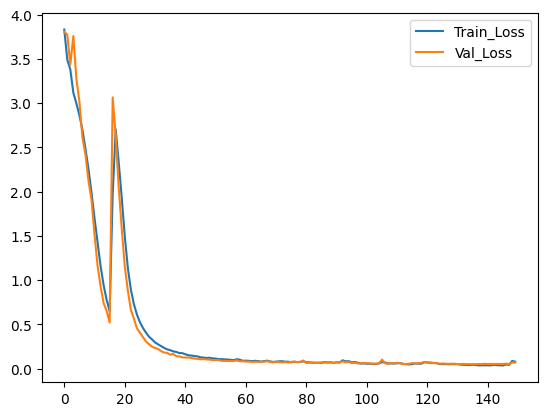

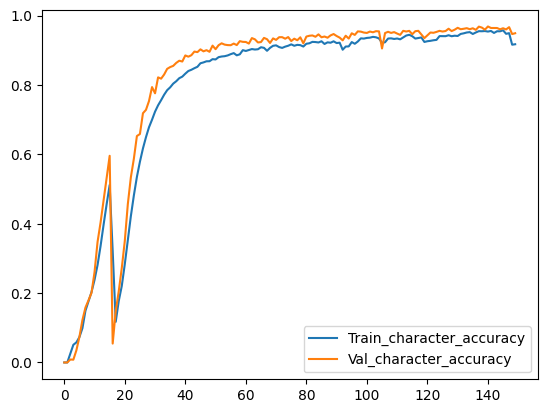

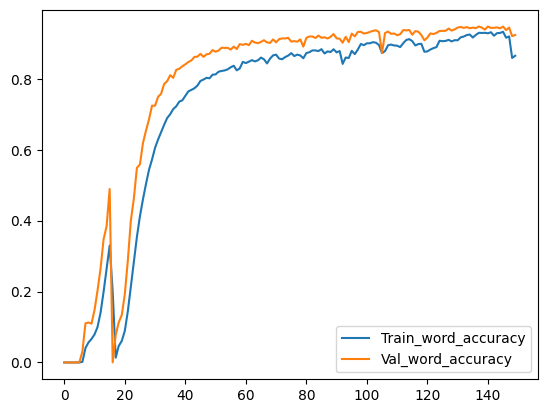

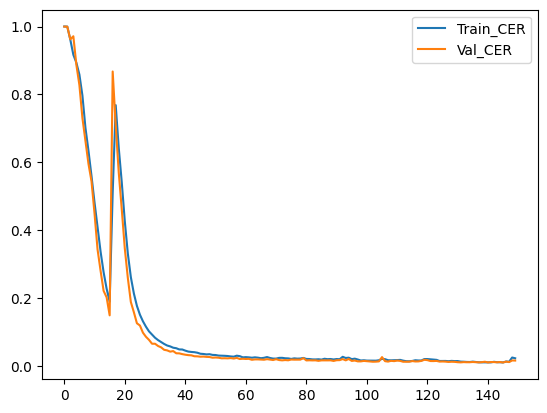

<Figure size 640x480 with 0 Axes>

In [29]:
importlib.reload(training_loop)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = {"path": "Models/checkpoints/v0.01","log_path":"Logs", "metrics":["Train_Loss", "Val_Loss", "Train_CER"  ,"Val_CER" , "Train_character_accuracy", "Train_word_accuracy", "Val_character_accuracy", "Val_word_accuracy"]}
plots = {"path": "Plots"}
train_CRNN = training_loop.Train(train_loader = train_data, val_loader = val_data, criterion=criterion, optimizer=optimizer, device = device, char_to_index=char_to_index, metrics=["character_accuracy", "word_accuracy", "CER"], num_epochs=150)
train_CRNN.fit(model=model,plots = plots, checkpoint= checkpoint)